In [59]:
import pandas as pd
import numpy as np
import openpyxl
from collections import OrderedDict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from skforecast.direct import ForecasterDirect
from skforecast.recursive import (
    ForecasterRecursive,
    ForecasterEquivalentDate)
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster

from lightgbm import LGBMRegressor
import plotly.graph_objs as go

# =============================================================================
# 1) Limpieza de data_ECR.xlsx → output.csv
# =============================================================================
class ExcelLoader(BaseEstimator, TransformerMixin):
    def __init__(self, filepath, sheet_name=None):
        self.filepath, self.sheet_name = filepath, sheet_name
    def fit(self, X, y=None): return self
    def transform(self, X=None):
        wb = openpyxl.load_workbook(self.filepath, data_only=True)
        sheet = wb.active if self.sheet_name is None else wb[self.sheet_name]
        data = [[str(cell) if cell is not None else '' for cell in row]
                for row in sheet.iter_rows(values_only=True)]
        df = pd.DataFrame(data)
        df.columns = df.iloc[0]
        return df.drop(index=0).reset_index(drop=True)

class ContextParser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        df = X.copy()
        ctx = ['DAY - Year','DAY - Month','DAY - Day']
        df[ctx] = df[ctx].replace(r'^\s*$', np.nan, regex=True).ffill()
        mask = df['Hour'].str.match(r'^\d{2}:\d{2}:\d{2}$')
        return df.loc[mask].reset_index(drop=True)

class DateConstructor(BaseEstimator, TransformerMixin):
    def __init__(self, year='DAY - Year', month='DAY - Month',
                 day='DAY - Day', hour='Hour'):
        self.year,self.month,self.day,self.hour = year,month,day,hour
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        df = X.copy()
        df[self.year] = pd.to_numeric(df[self.year], errors='coerce')
        df[self.day]  = pd.to_numeric(df[self.day],  errors='coerce')
        df['Hour_str'] = df[self.hour].str[:5]
        fecha = (
            df[self.year].astype(int).astype(str) + '-' +
            df[self.month]                        + '-' +
            df[self.day].astype(int).astype(str)  + ' ' +
            df['Hour_str']
        )
        df['fecha'] = pd.to_datetime(fecha,
                                     format='%Y-%B-%d %H:%M',
                                     errors='coerce')
        return df.dropna(subset=['fecha']).drop(columns=['Hour_str'])

class TemporalFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        df = X.copy(); ts = df['fecha']
        df['year']       = ts.dt.year
        df['month']      = ts.dt.month
        df['day']        = ts.dt.day
        df['hour']       = ts.dt.hour
        df['weekday']    = ts.dt.weekday
        df['is_weekend'] = ts.dt.weekday.isin([5,6]).astype(int)
        return df

class NumericCaster(BaseEstimator, TransformerMixin):
    def __init__(self, cols): self.cols = cols
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        df = X.copy()
        for c in self.cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        return df

class SupervisedImputer(BaseEstimator, TransformerMixin):
    def __init__(self, targets, features, random_state=42, n_estimators=100):
        self.targets,self.features = targets,features
        self.random_state,self.n_estimators = random_state,n_estimators
    def fit(self, X, y=None):
        df = X.copy(); self.models_ = {}
        for t in self.targets:
            train = df.dropna(subset=[t])
            if len(train):
                m = RandomForestRegressor(n_estimators=self.n_estimators,
                                          random_state=self.random_state)
                m.fit(train[self.features], train[t])
                self.models_[t] = m
        return self
    def transform(self, X, y=None):
        df = X.copy()
        for t,m in self.models_.items():
            mask = df[t].isna()
            if mask.any():
                df.loc[mask, t] = m.predict(df.loc[mask, self.features])
        return df

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols): self.cols = cols
    def fit(self, X, y=None): return self
    def transform(self, X, y=None): return X.drop(columns=self.cols, errors='ignore')

pipe_clean = Pipeline([
    ('load',    ExcelLoader('data_ECR.xlsx')),
    ('context', ContextParser()),
    ('dates',   DateConstructor()),
    ('temp',    TemporalFeatures()),
    ('cast',    NumericCaster(['AHT','TSF','ABA %'])),
    ('impute',  SupervisedImputer(
        targets=['AHT','TSF','ABA %'],
        features=['year','month','day','hour','weekday','is_weekend']
    )),
    ('drop',    DropColumns(['year','month','day','hour','weekday','is_weekend']))
])
df_out = pipe_clean.fit_transform(None)
df_out.to_csv('output.csv', index=False)


# =============================================================================
# 2) Merge → merged_output.csv (freq=30T)
# =============================================================================
metrics    = ['OFF Calls','Handled Calls','Real AHT','Real TSF','Real ABA%','Real ASA','Real ABA']
rename_map = {
    'Offered':'OFF Calls','Handled':'Handled Calls','AHT':'Real AHT',
    'TSF':'Real TSF','ABA %':'Real ABA%','Calls SL':'Real ABA','ASA':'Real ASA'
}
df1 = (pd.read_csv('output.csv', parse_dates=['fecha'])
         .rename(columns=rename_map)
         .set_index('fecha')[metrics])

df2 = pd.read_csv('data_jam.csv')
df2.columns = df2.columns.str.strip()
meses = {'enero':'January','febrero':'February','marzo':'March','abril':'April',
         'mayo':'May','junio':'June','julio':'July','agosto':'August',
         'septiembre':'September','octubre':'October','noviembre':'November','diciembre':'December'}
df2['mes_eng'] = df2['DATE_S - Mes'].str.lower().map(meses)
df2['fecha'] = pd.to_datetime(
    df2['DATE_S - Año'].astype(str)+'-'+df2['mes_eng']+'-'+df2['DATE_S - Día'].astype(str)+' '+df2['Interval_Group'],
    format='%Y-%B-%d %H:%M:%S', errors='coerce'
)
df2 = df2.rename(columns=rename_map).set_index('fecha')[metrics]

last_df2 = df2.index.max()
cutoff   = last_df2 + pd.Timedelta(minutes=30)
df1_tail = df1[df1.index >= cutoff].copy()

df_merged = pd.concat([df2.assign(source='df2'),
                       df1_tail.assign(source='df1')],
                      axis=0).asfreq('30T')

df_merged['Real TSF']  = (df_merged['Real TSF']  * 100).round(1)
df_merged['Real ABA%'] = (df_merged['Real ABA%'] * 100).round(1)
for c in ['OFF Calls','Handled Calls','Real ABA']:
    df_merged[c] = df_merged[c].astype(float)
df_merged = df_merged.drop(columns='source')
df_merged.to_csv('merged_output.csv')


# =============================================================================
# 3) División último año y recorte de df_merged
# =============================================================================
def dividir_ultimo_anio(df, col):
    serie = df[col].dropna()
    ultimo = serie.index.max()
    pmes   = pd.Timestamp(ultimo.year, ultimo.month, 1)
    ames   = pmes - pd.Timedelta(days=1)
    dia    = serie[serie.index.date == ames.date()]
    cortes = dia.index[dia.index.strftime('%H:%M')=='23:30']
    if not len(cortes):
        raise ValueError(f"No 23:30 en {ames.date()}")
    t_end = cortes[-1]
    t_start = t_end - pd.DateOffset(years=1)
    # alinear inicio a 00:00
    ini = serie.index[serie.index.strftime('%H:%M')=='00:00']
    if len(ini): t_start = ini[0]
    serie = serie.loc[t_start:t_end]
    total_days = (serie.index.max()-serie.index.min()).days
    dtr = int(total_days*0.8); dval = int(total_days*0.1)
    t1 = serie.index.min()+pd.Timedelta(days=dtr)
    t2 = t1 + pd.Timedelta(days=dval)
    # alinear a 23:30 / 00:00
    def last2330(s,t):
        c = s.index[(s.index<=t)&(s.index.strftime('%H:%M')=='23:30')]
        return c[-1] if len(c) else t
    def first0000(s,t):
        c = s.index[(s.index>=t)&(s.index.strftime('%H:%M')=='00:00')]
        return c[0] if len(c) else t
    t1, t2 = last2330(serie,t1), last2330(serie,t2)
    s1 = first0000(serie, serie.index.min())
    s2 = first0000(serie, t1+pd.Timedelta('30Min'))
    s3 = first0000(serie, t2+pd.Timedelta('30Min'))
    train = serie.loc[s1:t1]
    val   = serie.loc[s2:t2]
    test  = serie.loc[s3:t_end]
    print(f"Train {train.index.min()}—{train.index.max()} n={len(train)}")
    print(f" Val  {val.index.min()}—{val.index.max()} n={len(val)}")
    print(f" Test {test.index.min()}—{test.index.max()} n={len(test)}\n")
    return train, val, test

y_train, y_val, y_test = dividir_ultimo_anio(df_merged, 'OFF Calls')
y_consolid = pd.concat([y_train, y_val, y_test])
y_trainval = pd.concat([y_train, y_val])

# recorte de df_merged a ventana
t0, t1 = y_train.index.min(), y_test.index.max()
df_range = df_merged.loc[t0:t1]

# --- 4) Baseline (ya índice freq=30T preservado) ---
baseline = ForecasterEquivalentDate(offset=pd.DateOffset(days=1), n_offsets=1)
baseline.fit(y=y_trainval)
cv1 = TimeSeriesFold(steps=48, initial_train_size=len(y_trainval), refit=False)
mae_base,_ = backtesting_forecaster(
    forecaster=baseline,
    y=y_consolid,
    cv=cv1,
    metric='mean_absolute_error'
)
print("Baseline MAE:", mae_base)

# =============================================================================
# 5) Variables exógenas e interacciones sobre df_range
# =============================================================================
def crear_variables_exogenas_callcenter(df):
    df = df.copy(); df.index = pd.to_datetime(df.index)
    exog = pd.DataFrame(index=df.index)
    # temporal básicas …
    exog['day_of_week']   = df.index.dayofweek
    exog['month']         = df.index.month
    exog['hour']          = df.index.hour
    exog['minute']        = df.index.minute
    exog['day_of_year']   = df.index.day_of_year
    exog['week_of_year']  = df.index.isocalendar().week.astype(int)
    exog['quarter']       = df.index.quarter
    exog['is_month_start']= df.index.is_month_start.astype(int)
    exog['is_month_end']  = df.index.is_month_end.astype(int)
    exog['is_quarter_start']= df.index.is_quarter_start.astype(int)
    exog['is_quarter_end']  = df.index.is_quarter_end.astype(int)
    # cíclicas …
    exog['sin_hour']         = np.sin(2*np.pi*exog.hour/24)
    exog['cos_hour']         = np.cos(2*np.pi*exog.hour/24)
    exog['sin_day_of_week']  = np.sin(2*np.pi*exog.day_of_week/7)
    exog['cos_day_of_week']  = np.cos(2*np.pi*exog.day_of_week/7)
    exog['sin_month']        = np.sin(2*np.pi*exog.month/12)
    exog['cos_month']        = np.cos(2*np.pi*exog.month/12)
    exog['sin_week_of_year'] = np.sin(2*np.pi*exog.week_of_year/52)
    exog['cos_week_of_year'] = np.cos(2*np.pi*exog.week_of_year/52)
    # feriados y proximidades …
    feriados = pd.to_datetime([
        # … lista completa desde 2021 hasta 2028 …
    ])
    fechas = df.index.normalize()
    exog['is_holiday']         = fechas.isin(feriados).astype(int)
    exog['is_day_before_holiday']= fechas.isin(feriados - pd.Timedelta(days=1)).astype(int)
    exog['is_day_after_holiday'] = fechas.isin(feriados + pd.Timedelta(days=1)).astype(int)
    # semánticas
    exog['is_weekend']       = exog.day_of_week.isin([5,6]).astype(int)
    exog['is_working_hour']  = ((exog.hour>=6)&(exog.hour<20)).astype(int)
    exog['is_lunch_time']    = ((exog.hour>=12)&(exog.hour<14)).astype(int)
    exog['is_night_shift']   = ((exog.hour>=22)|(exog.hour<6)).astype(int)
    # slot de 30min
    exog['time_slot']     = exog.hour*2 + (exog.minute//30)
    exog['sin_time_slot']= np.sin(2*np.pi*exog.time_slot/48)
    exog['cos_time_slot']= np.cos(2*np.pi*exog.time_slot/48)
    return exog.fillna(0)

def crear_interacciones_exogenas(exog, cols, degree=2):
    avail = [c for c in cols if c in exog.columns]
    if not avail: return exog
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    poly.set_output(transform="pandas")
    dfp = poly.fit_transform(exog[avail])
    dfp.columns = [f"poly__{c}" for c in dfp.columns]
    dfp.index = exog.index
    return pd.concat([exog, dfp], axis=1)

poly_cols = [
    'sin_month','cos_month','sin_week_of_year','cos_week_of_year',
    'sin_day_of_week','cos_day_of_week','sin_hour','cos_hour',
    'is_holiday','is_day_before_holiday','is_day_after_holiday',
    'is_weekend','is_working_hour','is_lunch_time','is_night_shift',
    'sin_time_slot','cos_time_slot'
]
exog_int   = crear_interacciones_exogenas(exog, poly_cols)

# Matriz X y recorte a la misma ventana
X = (df_range[['OFF Calls']]
       .merge(exog_int, left_index=True, right_index=True, how='inner')
       .astype('float32'))

# =============================================================================
# 6) Recursivo con exógenas
# =============================================================================
end_val = y_val.index.max()
cv2 = TimeSeriesFold(steps=48, initial_train_size=len(y_trainval), refit=False)

forecaster = ForecasterRecursive(
    regressor       = LGBMRegressor(random_state=15926, verbose=-1),
    lags            = 48,
    window_features = RollingFeatures(stats=["mean"], window_sizes=48*3)
)
forecaster.fit(
    y    = y_trainval,
    exog = X.loc[:end_val, :]
)

mae_rec, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = X['OFF Calls'],
    exog       = X,
    cv         = cv2,
    metric     = 'mean_absolute_error',
    verbose    = True
)
print("Recursive MAE con exógenas:", mae_rec)

# =============================================================================
# 7) Plot Predicción vs Real
# =============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test.values,
                         mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['pred'],
                         mode='lines', name='Predicción'))
fig.update_layout(title="OFF Calls — Recursivo con Exógenas",
                  xaxis_title="Fecha", yaxis_title="Llamadas")
fig.show()





C:\Users\nicol\AppData\Local\Temp\ipykernel_9080\2882778539.py:159: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_merged = pd.concat([df2.assign(source='df2'),


Train 2021-04-01 00:00:00—2024-08-22 23:30:00 n=59514
 Val  2024-08-23 00:00:00—2025-01-24 23:30:00 n=7440
 Test 2025-01-25 00:00:00—2025-06-30 23:30:00 n=7534



TypeError: If `offset` is a pandas DateOffset, the index of `y` must be a pandas DatetimeIndex with frequency.

Lun    10704
Mar    10704
Mié    10704
Jue    10704
Vie    10704
Sáb    10704
Dom    10696
Name: OFF Calls, dtype: int64


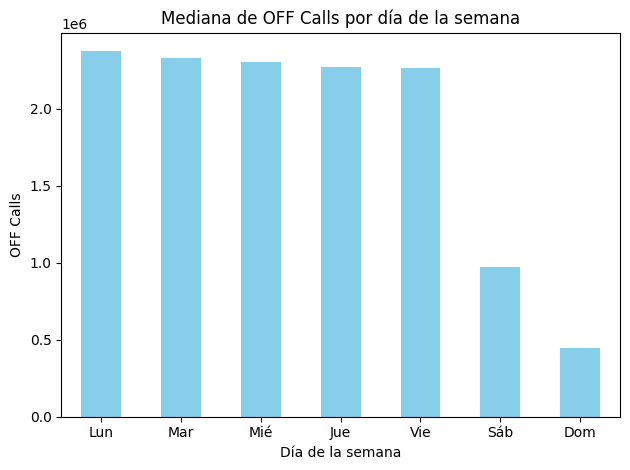

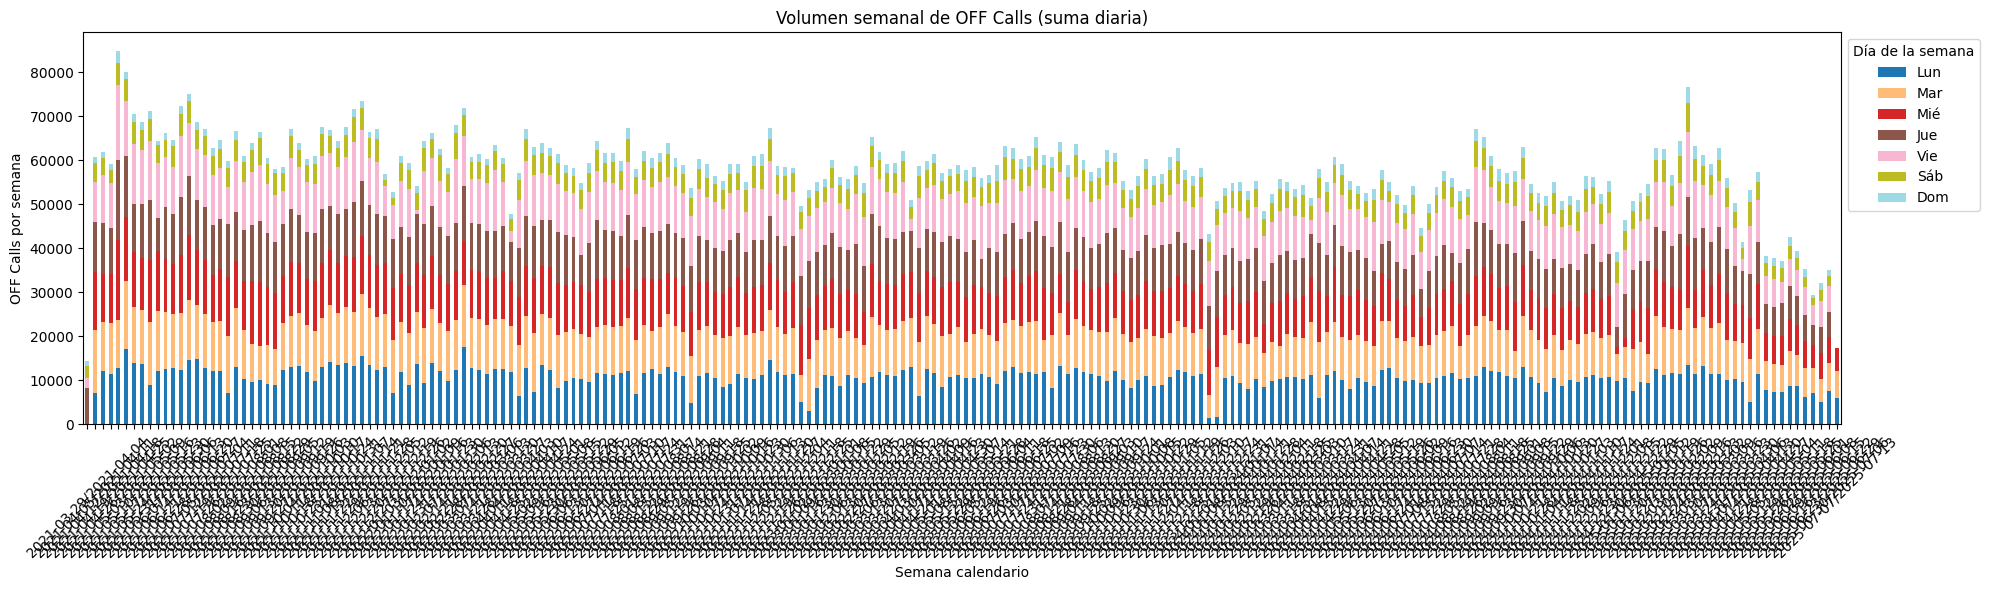

In [34]:
df_merged['weekday'] = df_merged.index.weekday  # 0 = Lunes, ..., 6 = Domingo
conteo_por_dia = df_merged['OFF Calls'].groupby(df_merged['weekday']).count()
conteo_por_dia.index = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
print(conteo_por_dia)
import matplotlib.pyplot as plt

dias = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
mediana = df_merged.groupby('weekday')['OFF Calls'].sum()
mediana.index = dias

mediana.plot(kind='bar', title='Mediana de OFF Calls por día de la semana', color='skyblue')
plt.ylabel('OFF Calls')
plt.xlabel('Día de la semana')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df_merged['year_week'] = df_merged.index.to_period('W')    # Año + semana 
pivot_semana = df_merged.groupby(['year_week', 'weekday'])['OFF Calls'].sum().unstack(level=1)
pivot_semana.columns = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
pivot_semana.plot(kind='bar', stacked=True, figsize=(20,6), colormap='tab20')
plt.title("Volumen semanal de OFF Calls (suma diaria)")
plt.ylabel("OFF Calls por semana")
plt.xlabel("Semana calendario")
plt.xticks(rotation=45)
plt.legend(title="Día de la semana", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

Lun    10704
Mar    10704
Mié    10704
Jue    10704
Vie    10704
Sáb    10704
Dom    10696
Name: Handled Calls, dtype: int64


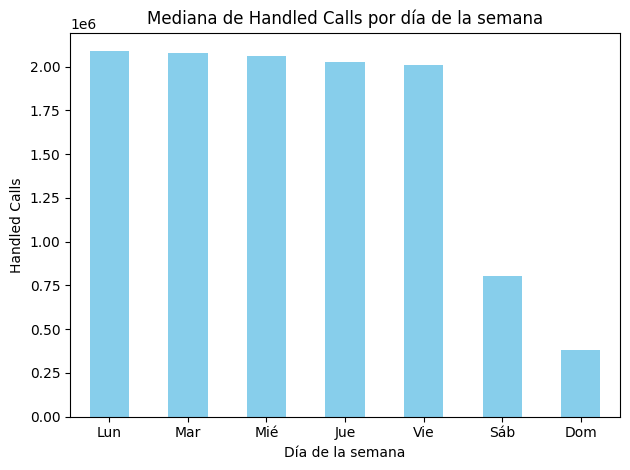

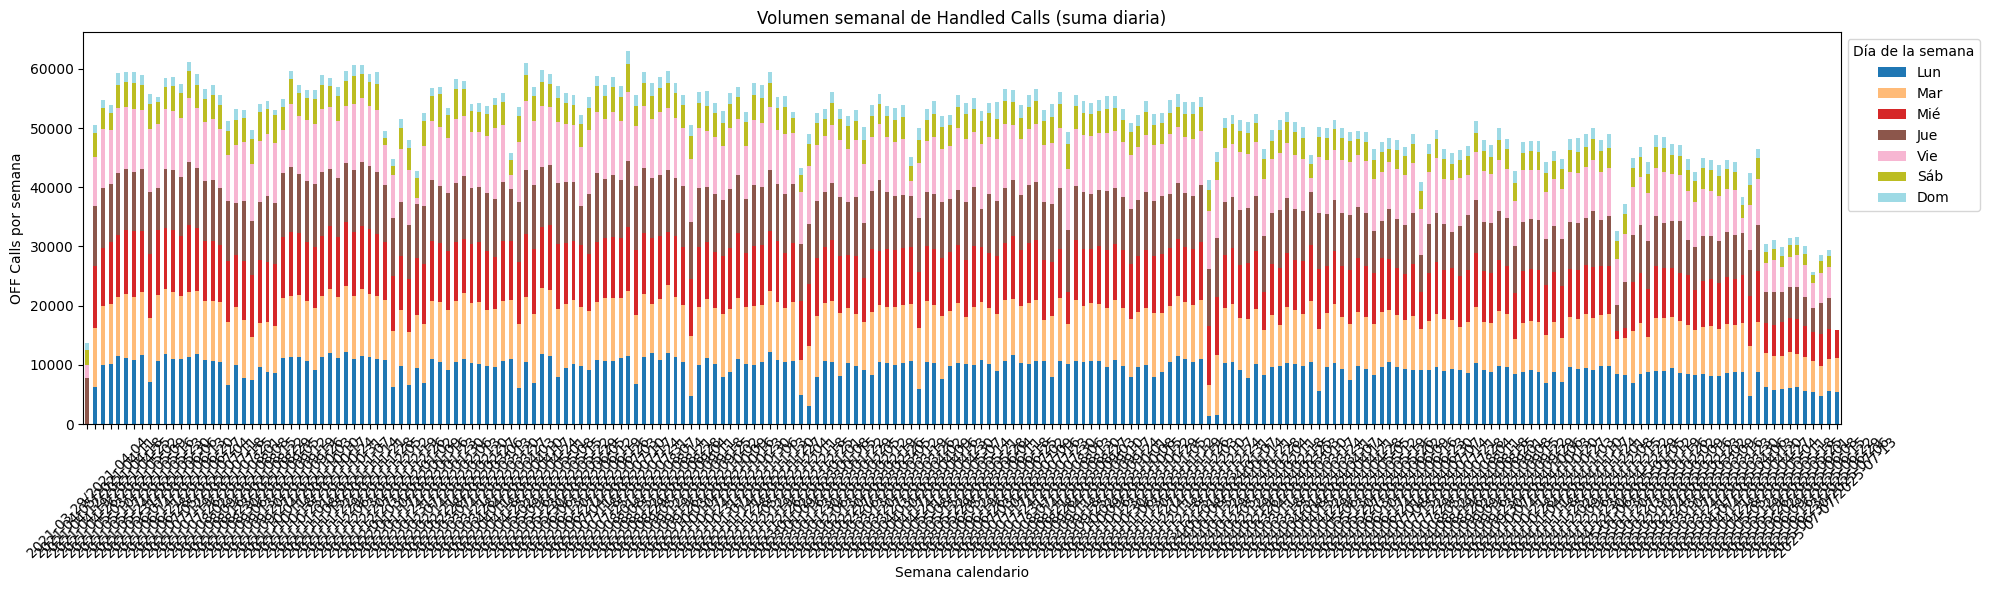

In [35]:
df_merged['weekday'] = df_merged.index.weekday  # 0 = Lunes, ..., 6 = Domingo
conteo_por_dia = df_merged['Handled Calls'].groupby(df_merged['weekday']).count()
conteo_por_dia.index = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
print(conteo_por_dia)
import matplotlib.pyplot as plt

dias = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
mediana = df_merged.groupby('weekday')['Handled Calls'].sum()
mediana.index = dias

mediana.plot(kind='bar', title='Mediana de Handled Calls por día de la semana', color='skyblue')
plt.ylabel('Handled Calls')
plt.xlabel('Día de la semana')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df_merged['year_week'] = df_merged.index.to_period('W')    # Año + semana 
pivot_semana = df_merged.groupby(['year_week', 'weekday'])['Handled Calls'].sum().unstack(level=1)
pivot_semana.columns = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
pivot_semana.plot(kind='bar', stacked=True, figsize=(20,6), colormap='tab20')
plt.title("Volumen semanal de Handled Calls (suma diaria)")
plt.ylabel("OFF Calls por semana")
plt.xlabel("Semana calendario")
plt.xticks(rotation=45)
plt.legend(title="Día de la semana", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

Lun    10704
Mar    10704
Mié    10704
Jue    10704
Vie    10704
Sáb    10704
Dom    10696
Name: Real AHT, dtype: int64


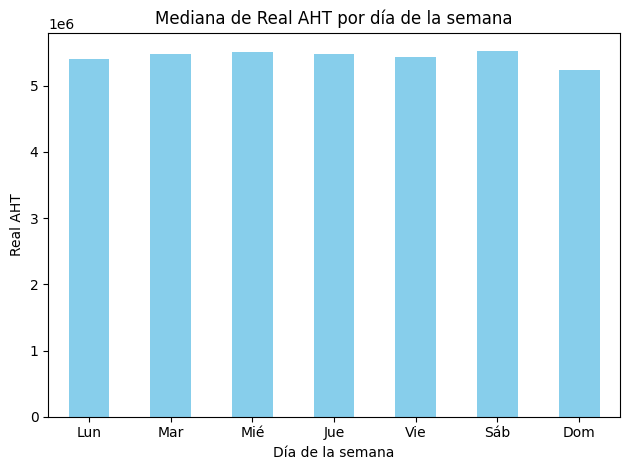

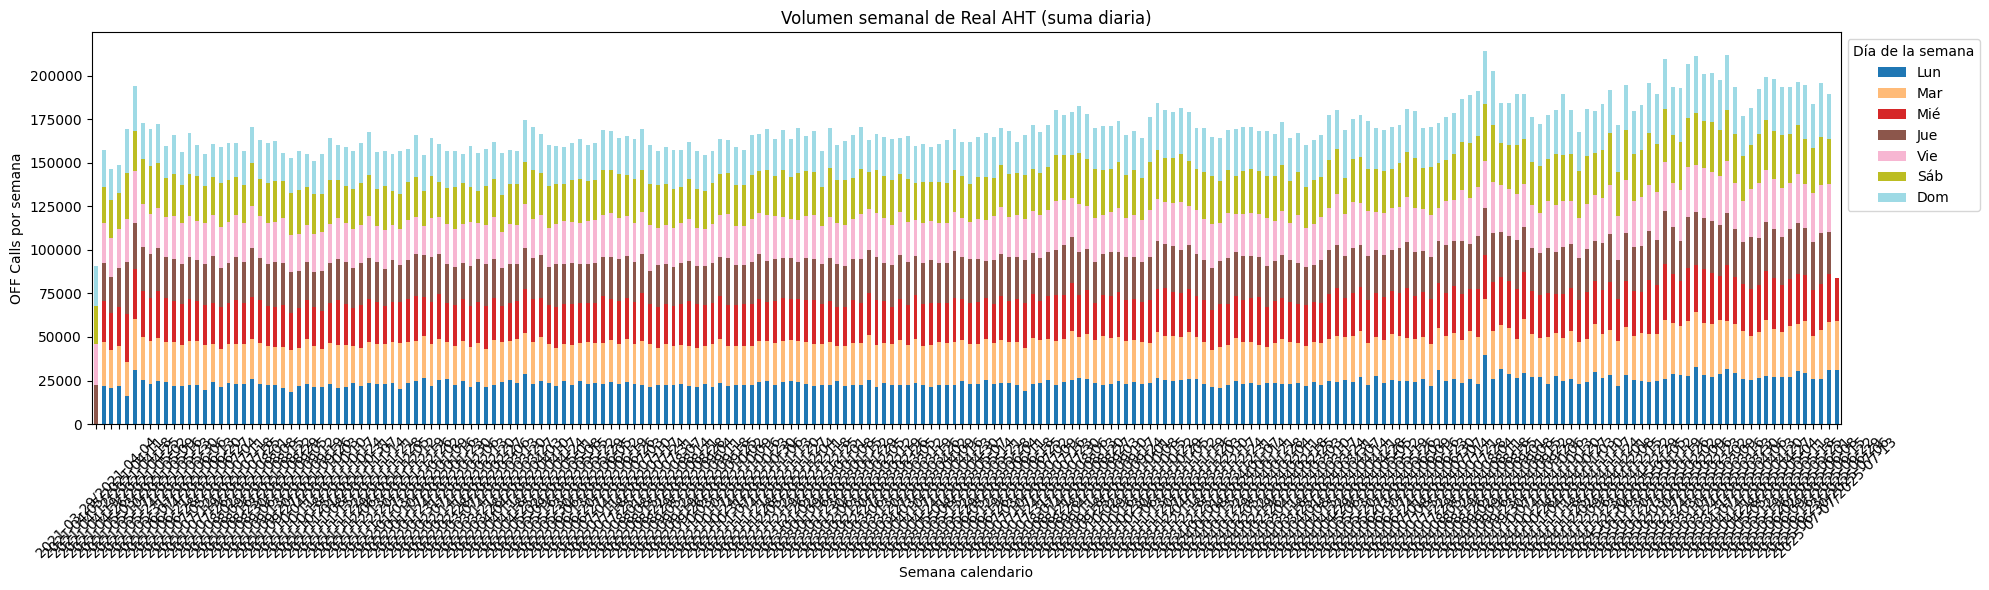

In [36]:
df_merged['weekday'] = df_merged.index.weekday  # 0 = Lunes, ..., 6 = Domingo
conteo_por_dia = df_merged['Real AHT'].groupby(df_merged['weekday']).count()
conteo_por_dia.index = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
print(conteo_por_dia)
import matplotlib.pyplot as plt

dias = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
mediana = df_merged.groupby('weekday')['Real AHT'].sum()
mediana.index = dias

mediana.plot(kind='bar', title='Mediana de Real AHT por día de la semana', color='skyblue')
plt.ylabel('Real AHT')
plt.xlabel('Día de la semana')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df_merged['year_week'] = df_merged.index.to_period('W')    # Año + semana 
pivot_semana = df_merged.groupby(['year_week', 'weekday'])['Real AHT'].sum().unstack(level=1)
pivot_semana.columns = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
pivot_semana.plot(kind='bar', stacked=True, figsize=(20,6), colormap='tab20')
plt.title("Volumen semanal de Real AHT (suma diaria)")
plt.ylabel("OFF Calls por semana")
plt.xlabel("Semana calendario")
plt.xticks(rotation=45)
plt.legend(title="Día de la semana", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

Lun    10704
Mar    10704
Mié    10704
Jue    10704
Vie    10704
Sáb    10704
Dom    10696
Name: Real TSF, dtype: int64


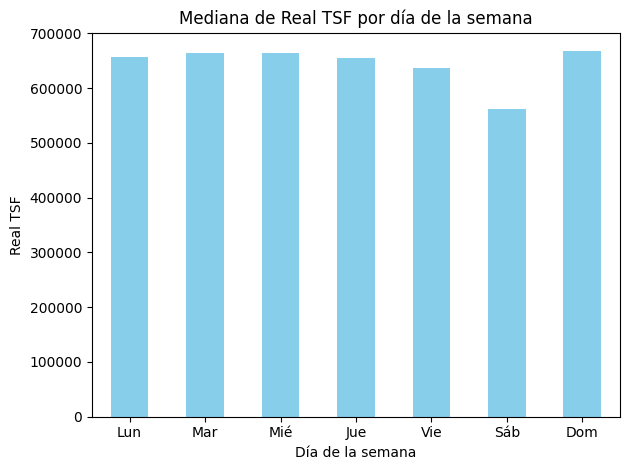

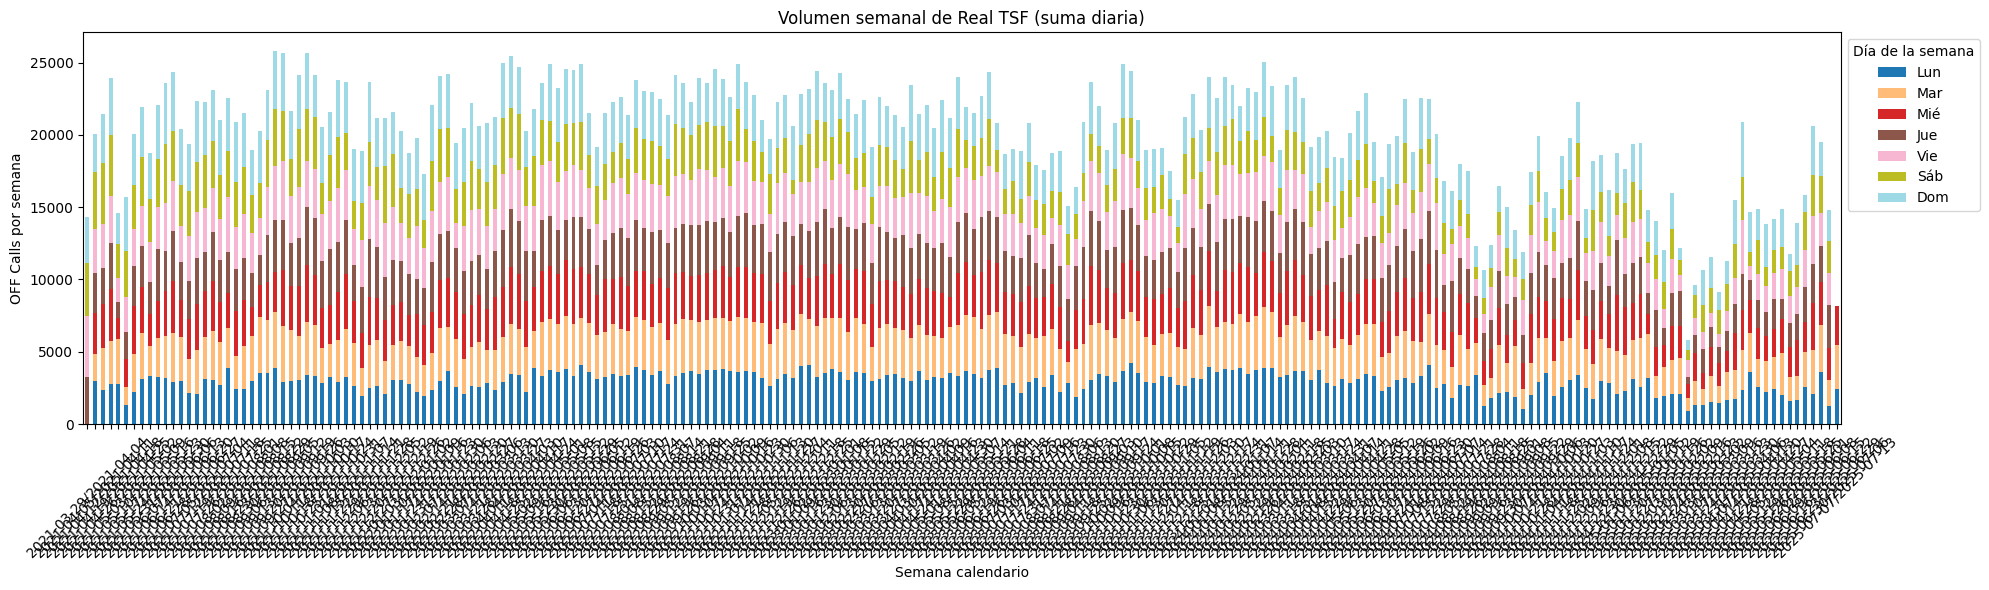

In [37]:
df_merged['weekday'] = df_merged.index.weekday  # 0 = Lunes, ..., 6 = Domingo
conteo_por_dia = df_merged['Real TSF'].groupby(df_merged['weekday']).count()
conteo_por_dia.index = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
print(conteo_por_dia)
import matplotlib.pyplot as plt

dias = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
mediana = df_merged.groupby('weekday')['Real TSF'].sum()
mediana.index = dias

mediana.plot(kind='bar', title='Mediana de Real TSF por día de la semana', color='skyblue')
plt.ylabel('Real TSF')
plt.xlabel('Día de la semana')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
df_merged['year_week'] = df_merged.index.to_period('W')    # Año + semana 
pivot_semana = df_merged.groupby(['year_week', 'weekday'])['Real TSF'].sum().unstack(level=1)
pivot_semana.columns = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
pivot_semana.plot(kind='bar', stacked=True, figsize=(20,6), colormap='tab20')
plt.title("Volumen semanal de Real TSF (suma diaria)")
plt.ylabel("OFF Calls por semana")
plt.xlabel("Semana calendario")
plt.xticks(rotation=45)
plt.legend(title="Día de la semana", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()